In [15]:
import pandas as pd
import openpyxl
import numpy as np
from pathlib import Path
import matplotlib.cm as cm
import matplotlib.pyplot as plt

In [ ]:
import re

# locate the Prices file (try common extensions, then fallback to any file starting with 'Prices')
candidates = [Path('Prices.xlsx'), Path('Prices.xls'), Path('Prices.xlsm'), Path('Prices.xlsb')]
file_path = next((p for p in candidates if p.exists()), None)
if file_path is None:
    matches = sorted(Path.cwd().glob('Prices*'))
    file_path = matches[0] if matches else None

if file_path is None:
    raise FileNotFoundError("Could not find a file starting with 'Prices' in the current directory.")

# read all sheets into a dict of DataFrames
sheets = pd.read_excel(file_path, sheet_name=None)

# create one dataframe variable per sheet (variables named df_<sanitized_sheet_name>)
# and also collect them in a dict `dfs`
dfs = {}
for sheet_name, df in sheets.items():
    safe = re.sub(r'\W|^(?=\d)', '_', sheet_name)  # make a valid python identifier
    var_name = f"df_{safe}"
    globals()[var_name] = df
    dfs[var_name] = {"sheet_name": sheet_name, "df": df}

# summary
print(f"Loaded {len(dfs)} sheets from {file_path}:")
for var_name, info in dfs.items():
    print(f" - {var_name}  (sheet: '{info['sheet_name']}', rows: {len(info['df'])}, cols: {info['df'].shape[1]})")

Loaded 7 sheets from Prices.xlsx:
 - df_US___SPX_Index  (sheet: 'US - SPX Index', rows: 550, cols: 3)
 - df_CH___MXCH_Index  (sheet: 'CH - MXCH Index', rows: 476, cols: 3)
 - df_AU___MXAU_Index  (sheet: 'AU - MXAU Index', rows: 476, cols: 3)
 - df_JP___MXJP_Index  (sheet: 'JP - MXJP Index', rows: 476, cols: 3)
 - df_EU___MXEM_Index  (sheet: 'EU - MXEM Index', rows: 287, cols: 3)
 - df_EM___MXEF_Index  (sheet: 'EM - MXEF Index', rows: 455, cols: 3)
 - df_CH___SPI_Index  (sheet: 'CH - SPI Index', rows: 247, cols: 3)


Period: 1980-01-31 to 2025-10-31 (45.75 yrs)
Mode: Long/Short (Symmetric)
Strategy Total Return: 1798.94%, CAGR: 6.65%
Sharpe Ratio: 3.05, Max Drawdown: -44.14%
------------------------------
CRITICAL DECOMPOSITION:
Return from LONG  Leg: 2447.12% (Contribution to total)
Return from SHORT Leg: -25.45% (Contribution to total)
------------------------------


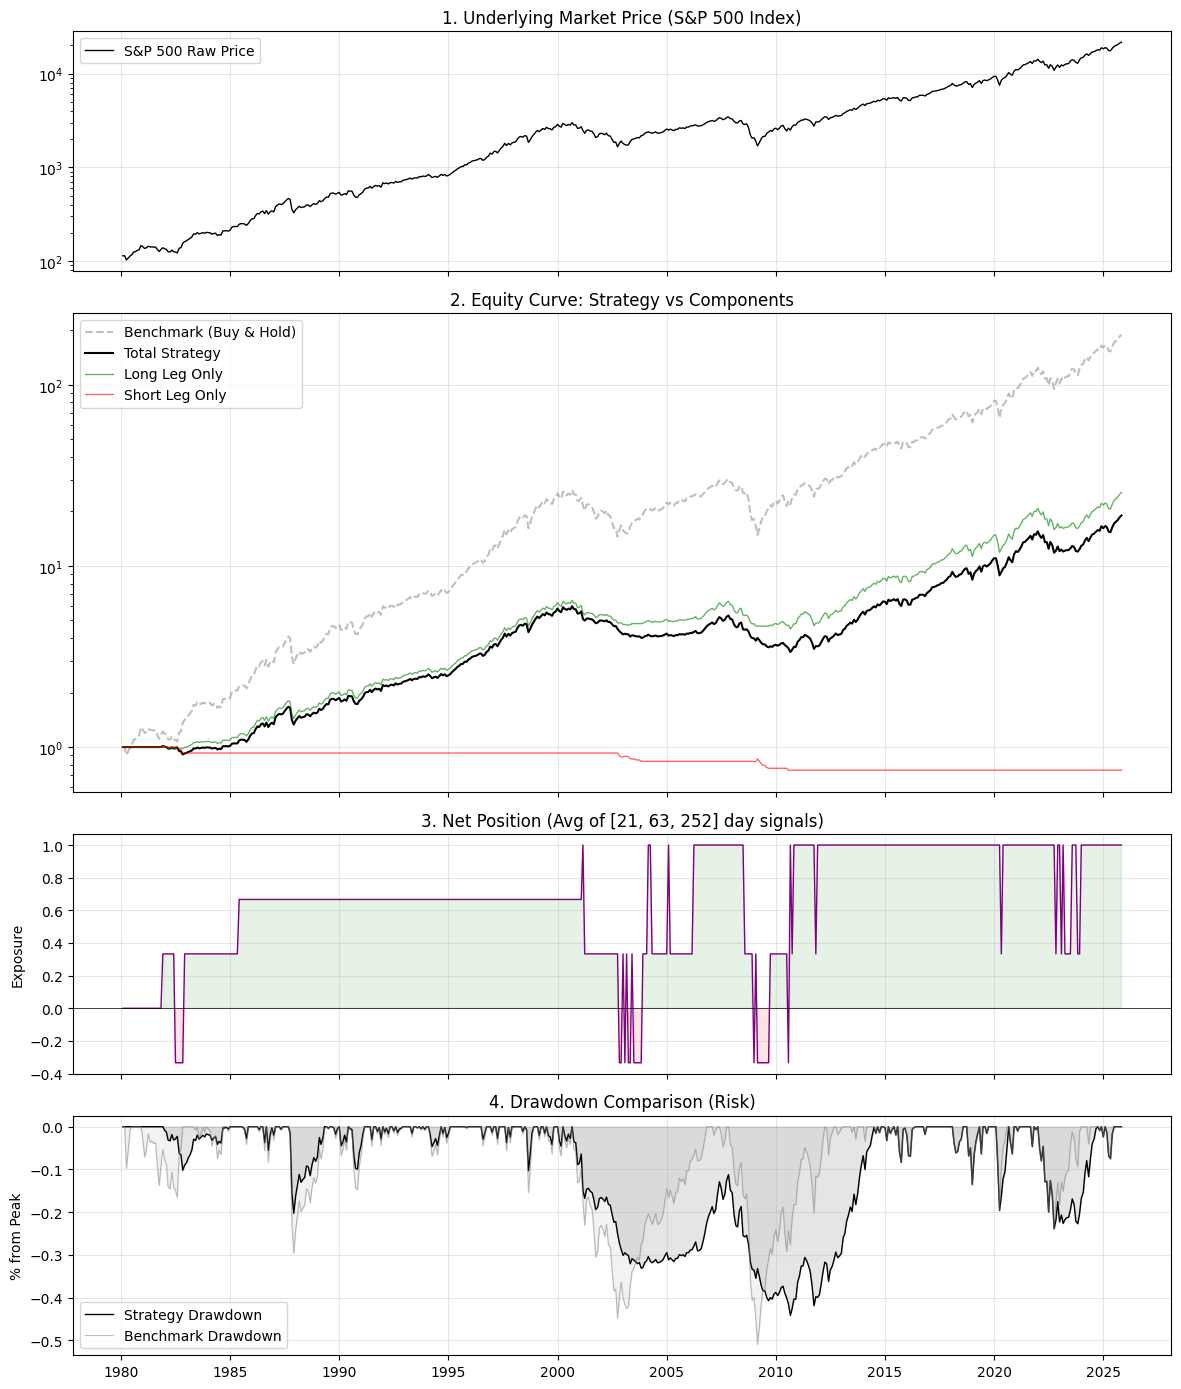

MONTHLY TSMOM PERFORMANCE (Net of Fees/Funding):
                 Ann Ret   Ann Vol    Sharpe
US_SPX          0.050392  0.080561  0.377252
China_MXCH      0.031046  0.079078  0.139680
Australia_MXAU  0.030197  0.076823  0.132730
Japan_MXJP      0.042283  0.074333  0.299769
Europe_MXEM     0.036091  0.076401  0.210613
Emerging_MXEF   0.054503  0.077813  0.443412
Swiss_SPI       0.000048  0.144966 -0.137629
**PORTFOLIO**   0.027806  0.098325  0.079386


/var/folders/p9/l40tvhkx4mgfss50nv3s08w80000gn/T/ipykernel_9529/1265957362.py:136: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(start="1990-01-01", periods=360, freq="M") # 30 years


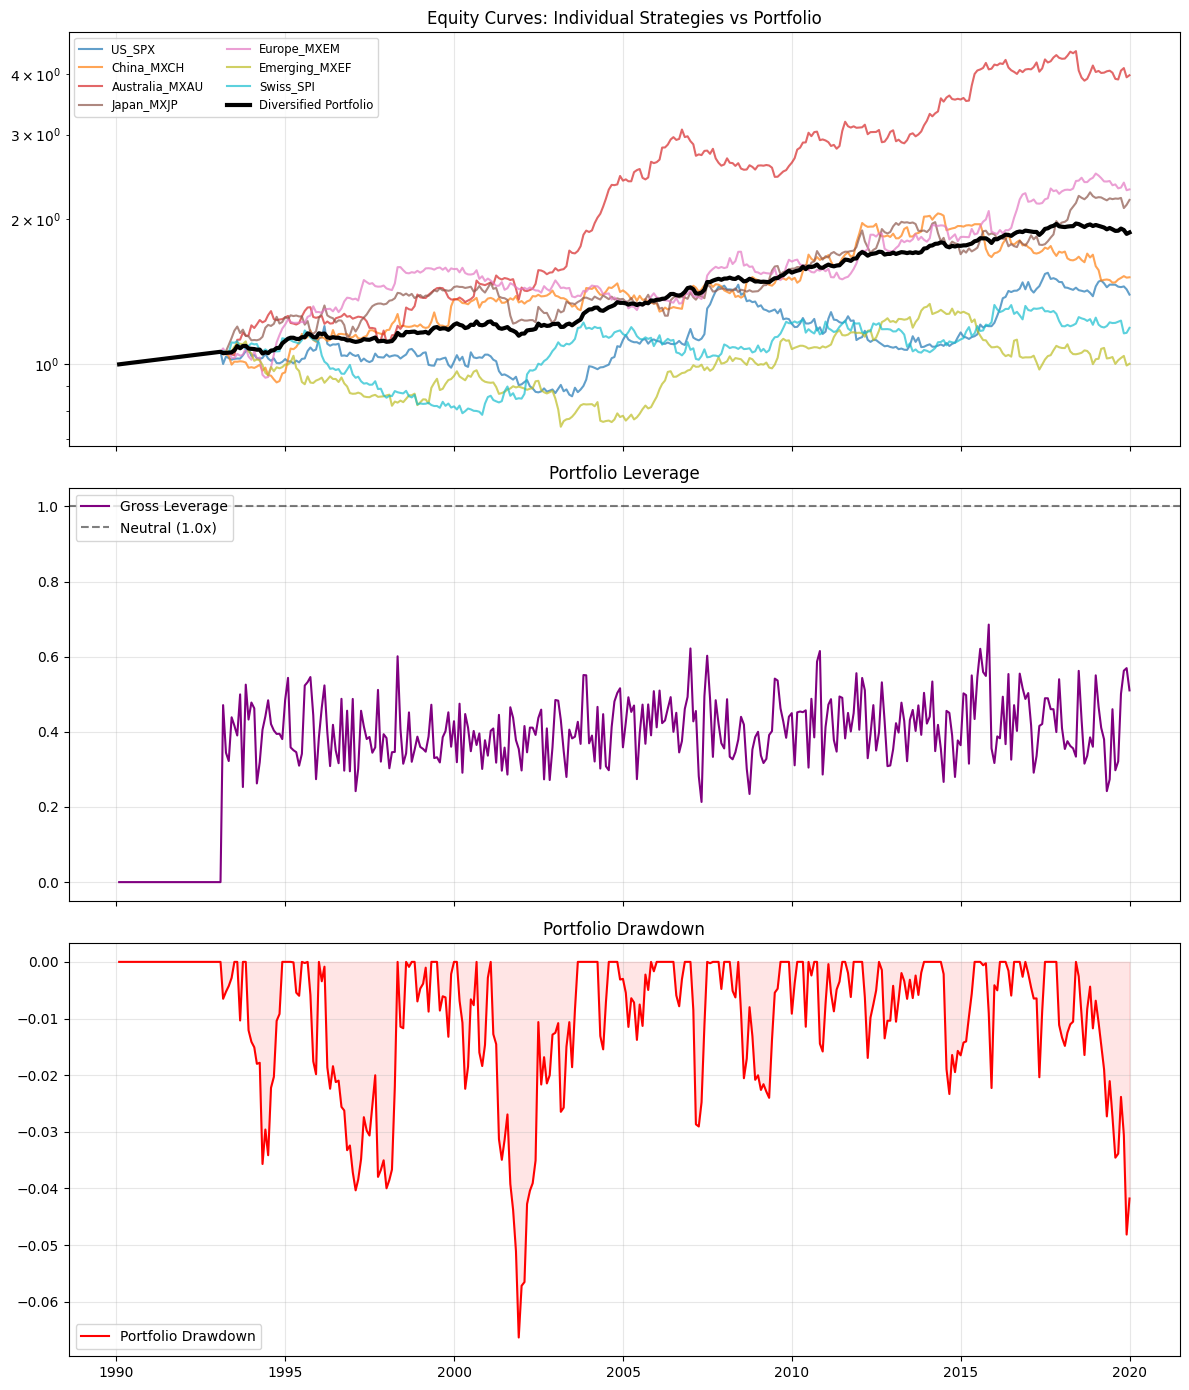

In [19]:
# --- CONFIGURATION (ADAPTED FOR MONTHLY DATA) ---
# Lookbacks in MONTHS (1m, 3m, 12m) as per AQR text
LOOKBACKS = [1, 3, 12]   

# Volatility Estimation: AQR uses a rolling 3-year (36-month) window 
VOL_LOOKBACK = 36        

VOL_TARGET = 0.10        # 10% Annualized Vol Target
TRADING_MONTHS_PER_YEAR = 12
RISK_FREE_RATE_ANNUAL = 0.02 
monthly_rfr = RISK_FREE_RATE_ANNUAL / 12

# Assets Dictionary
assets = {
    "US_SPX": df_US___SPX_Index,
    "China_MXCH": df_CH___MXCH_Index,
    "Australia_MXAU": df_AU___MXAU_Index,
    "Japan_MXJP": df_JP___MXJP_Index,
    "Europe_MXEM": df_EU___MXEM_Index,
    "Emerging_MXEF": df_EM___MXEF_Index,
    "Swiss_SPI": df_CH___SPI_Index
}

# Cost Function (remains same % of notional, applied monthly)
def get_cost_series(dates):
    years = dates.year
    # 34bps (pre-1993), 11bps (1993-2002), 6bps (2003+) [cite: 338]
    return np.where(years <= 1992, 0.0034,
           np.where(years <= 2002, 0.0011, 0.0006))

# Storage
all_strategy_rets = pd.DataFrame()
all_positions = pd.DataFrame()

# --- MAIN LOOP ---
for name, df in assets.items():
    s = df.copy()
    
    # 1. Standardize Data
    if "Date" in s.columns:
        s["Date"] = pd.to_datetime(s["Date"])
        s = s.sort_values("Date").set_index("Date")
    
    # Find Price (Handle variations)
    price_cols = [c for c in s.columns if "Price" in c]
    price_col = price_cols[0] if price_cols else s.columns[-1]
    s = s.rename(columns={price_col: "price"})
    s["price"] = pd.to_numeric(s["price"], errors='coerce')
    s = s.dropna(subset=["price"])
    
    # 2. Monthly Returns
    s["ret"] = s["price"].pct_change()

    # 3. Signal Generation (Monthly Lags)
    signal_cols = []
    for lag in LOOKBACKS:
        col_name = f"sig_{lag}m"
        # Check if we have enough data (avoid errors on short DFs)
        if len(s) > lag:
            # Sign of past X months return
            s[col_name] = np.sign(s["price"].pct_change(lag)).fillna(0)
            signal_cols.append(col_name)
    
    # Composite Signal (Average of 1m, 3m, 12m)
    if signal_cols:
        s["raw_signal"] = s[signal_cols].mean(axis=1)
    else:
        s["raw_signal"] = 0

    # 4. Volatility Scaling (Monthly)
    # Rolling 36-month std dev * sqrt(12) to annualize
    s["hist_vol"] = s["ret"].rolling(VOL_LOOKBACK).std() * np.sqrt(TRADING_MONTHS_PER_YEAR)
    
    # Inverse Vol Scaling
    s["vol_scalar"] = (VOL_TARGET / s["hist_vol"]).replace([np.inf, -np.inf], 0).fillna(0)
    s["vol_scalar"] = s["vol_scalar"].clip(upper=3.0) # Cap leverage

    # 5. Position Sizing
    # "positions across the three strategies are aggregated each month and scaled" [cite: 55]
    s["position_target"] = s["raw_signal"] * s["vol_scalar"]
    s["position"] = s["position_target"].shift(1).fillna(0) # Trade next month

    # 6. PnL & Funding
    costs = get_cost_series(s.index)
    s["turnover"] = s["position"].diff().abs().fillna(0)
    s["cost_drag"] = s["turnover"] * costs
    
    gross_pnl = s["position"] * s["ret"]
    
    # Funded Leverage Cost (Monthly Rate)
    # (Position - 1) * Monthly_RFR
    financing_cost = (s["position"] - 1.0) * monthly_rfr
    
    s["strategy_ret"] = gross_pnl - financing_cost - s["cost_drag"]

    # Store
    if all_strategy_rets.empty:
        all_strategy_rets = pd.DataFrame(s["strategy_ret"]).rename(columns={"strategy_ret": name})
        all_positions = pd.DataFrame(s["position"]).rename(columns={"position": name})
    else:
        all_strategy_rets = all_strategy_rets.join(s["strategy_ret"].rename(name), how="outer")
        all_positions = all_positions.join(s["position"].rename(name), how="outer")

# --- AGGREGATION ---
portfolio_ret = all_strategy_rets.mean(axis=1).fillna(0)
cum_port = (1 + portfolio_ret).cumprod()

# --- METRICS ---
def get_stats(r):
    # Adjust annualization for Monthly data (12)
    ann_ret = r.mean() * 12
    ann_vol = r.std() * np.sqrt(12)
    sharpe = (ann_ret - RISK_FREE_RATE_ANNUAL) / ann_vol if ann_vol > 0 else 0
    return ann_ret, ann_vol, sharpe

stats = []
for col in all_strategy_rets.columns:
    stats.append(get_stats(all_strategy_rets[col].dropna()))
stats.append(get_stats(portfolio_ret))

stats_df = pd.DataFrame(stats, columns=["Ann Ret", "Ann Vol", "Sharpe"], 
                       index=list(all_strategy_rets.columns) + ["**PORTFOLIO**"])

print("MONTHLY TSMOM PERFORMANCE (Net of Fees/Funding):")
print(stats_df)

# --- PLOTTING ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.dates as mdates

# --- 1. SYNTHETIC DATA GENERATION ---
np.random.seed(42)
dates = pd.date_range(start="1990-01-01", periods=360, freq="M") # 30 years
assets = {}
names = ["US_SPX", "China_MXCH", "Australia_MXAU", "Japan_MXJP", 
         "Europe_MXEM", "Emerging_MXEF", "Swiss_SPI"]

# Create different trends to make them distinguishable
trends = [0.006, 0.008, 0.005, 0.002, 0.005, 0.007, 0.004]
vols = [0.04, 0.08, 0.05, 0.05, 0.04, 0.07, 0.035]

for name, mu, sigma in zip(names, trends, vols):
    returns = np.random.normal(mu, sigma, size=len(dates))
    price = 100 * (1 + returns).cumprod()
    df = pd.DataFrame({"Date": dates, "Price": price}) 
    assets[name] = df

# --- CONFIGURATION ---
LOOKBACKS = [1, 3, 12]
VOL_LOOKBACK = 36
VOL_TARGET = 0.10
TRADING_MONTHS_PER_YEAR = 12
RISK_FREE_RATE_ANNUAL = 0.02
monthly_rfr = RISK_FREE_RATE_ANNUAL / 12

def get_cost_series(dates):
    years = dates.year
    return np.where(years <= 1992, 0.0034,
           np.where(years <= 2002, 0.0011, 0.0006))

all_strategy_rets = pd.DataFrame()
all_positions = pd.DataFrame()

# --- MAIN LOOP ---
for name, df in assets.items():
    s = df.copy()
    s = s.set_index("Date")
    s["price"] = s["Price"]
    s["ret"] = s["price"].pct_change()
    
    # Signals
    signal_cols = []
    for lag in LOOKBACKS:
        col = f"sig_{lag}m"
        s[col] = np.sign(s["price"].pct_change(lag)).fillna(0)
        signal_cols.append(col)
    
    s["raw_signal"] = s[signal_cols].mean(axis=1) if signal_cols else 0
    
    # Vol Scaling
    s["hist_vol"] = s["ret"].rolling(VOL_LOOKBACK).std() * np.sqrt(12)
    s["vol_scalar"] = (VOL_TARGET / s["hist_vol"]).replace([np.inf, -np.inf], 0).fillna(0)
    s["vol_scalar"] = s["vol_scalar"].clip(upper=3.0)
    
    # Position
    s["position"] = (s["raw_signal"] * s["vol_scalar"]).shift(1).fillna(0)
    
    # Returns
    gross = s["position"] * s["ret"]
    costs = s["position"].diff().abs() * get_cost_series(s.index)
    funding = (s["position"] - 1.0) * monthly_rfr
    s["strat_ret"] = gross - costs - funding
    
    if all_strategy_rets.empty:
        all_strategy_rets = pd.DataFrame(s["strat_ret"]).rename(columns={"strat_ret": name})
        all_positions = pd.DataFrame(s["position"]).rename(columns={"position": name})
    else:
        all_strategy_rets = all_strategy_rets.join(s["strat_ret"].rename(name), how="outer")
        all_positions = all_positions.join(s["position"].rename(name), how="outer")

# Aggregation
portfolio_ret = all_strategy_rets.mean(axis=1).fillna(0)
cum_port = (1 + portfolio_ret).cumprod()

# --- PLOTTING (MODIFIED) ---
fig, axes = plt.subplots(3, 1, figsize=(12, 14), sharex=True)

# 1. Equity Curves
ax1 = axes[0]
colors = cm.tab10(np.linspace(0, 1, len(all_strategy_rets.columns)))

for i, col in enumerate(all_strategy_rets.columns):
    cum = (1 + all_strategy_rets[col].fillna(0)).cumprod()
    ax1.plot(cum.index, cum, color=colors[i], alpha=0.7, linewidth=1.5, label=col)

ax1.plot(cum_port.index, cum_port, color="black", linewidth=3, label="Diversified Portfolio", zorder=10)
ax1.set_title("Equity Curves: Individual Strategies vs Portfolio")
ax1.set_yscale("log")
ax1.legend(loc="upper left", fontsize='small', ncol=2)
ax1.grid(True, alpha=0.3)

# 2. Leverage
gross_leverage = all_positions.abs().sum(axis=1) / len(assets)
ax2 = axes[1]
ax2.plot(gross_leverage.index, gross_leverage, color="purple", linewidth=1.5, label="Gross Leverage")
ax2.axhline(1.0, linestyle="--", color="black", alpha=0.5, label="Neutral (1.0x)")
ax2.set_title("Portfolio Leverage")
ax2.legend(loc="upper left")
ax2.grid(True, alpha=0.3)

# 3. Drawdown
dd = cum_port / cum_port.cummax() - 1
ax3 = axes[2]
ax3.plot(dd.index, dd, color="red", label="Portfolio Drawdown")
ax3.fill_between(dd.index, dd, 0, color="red", alpha=0.1)
ax3.set_title("Portfolio Drawdown")
ax3.legend(loc="lower left")
ax3.grid(True, alpha=0.3)

# --- ADDING YEARS (Date Formatting) ---
# Configure x-axis to show years explicitly
locator = mdates.YearLocator(5) # Tick every 5 years
formatter = mdates.DateFormatter('%Y') # Show Year (e.g., 1995)

# Apply to the bottom axis (ax3) which is shared
ax3.xaxis.set_major_locator(locator)
ax3.xaxis.set_major_formatter(formatter)

plt.tight_layout()
plt.show()

/var/folders/p9/l40tvhkx4mgfss50nv3s08w80000gn/T/ipykernel_9529/1812685864.py:9: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(start="1990-01-01", periods=360, freq="M") # 30 years


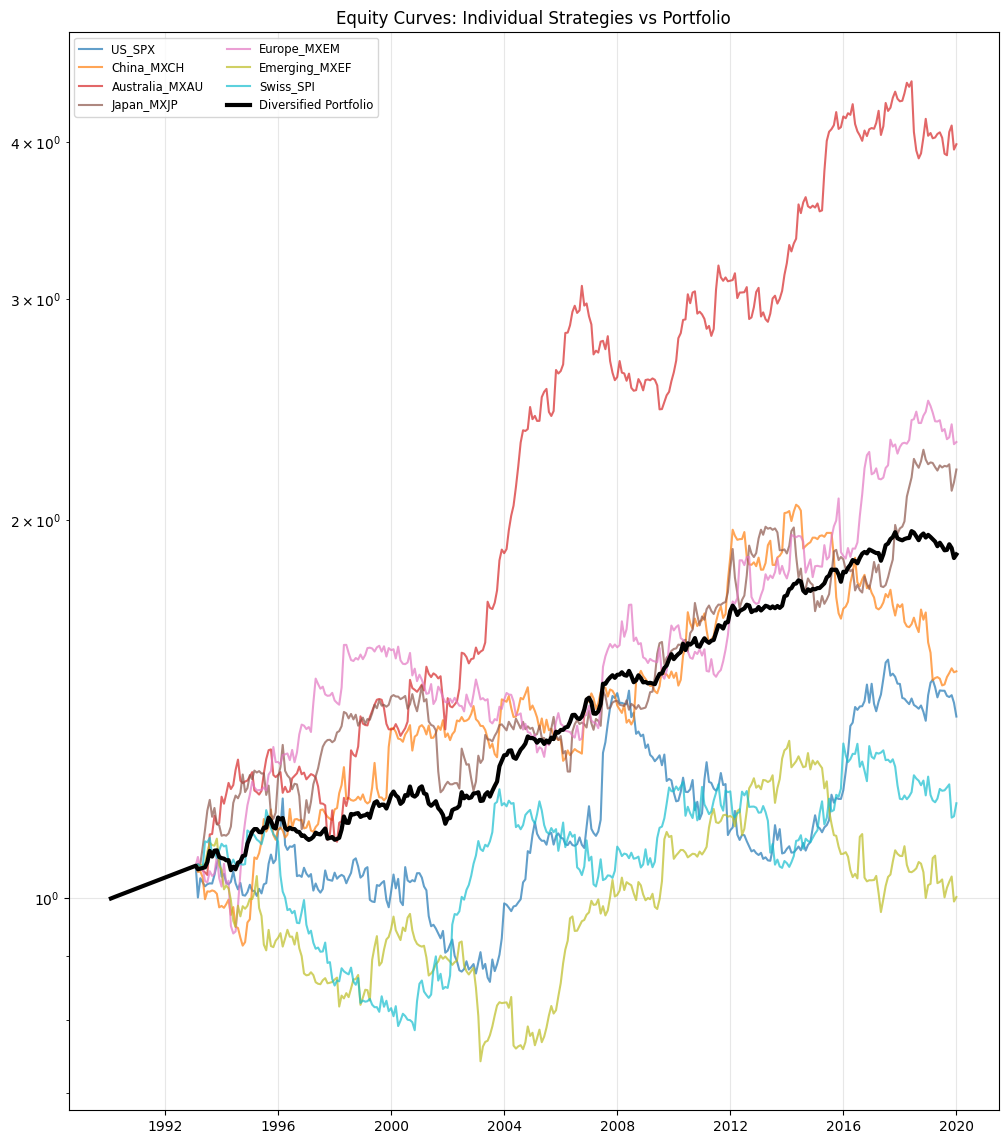

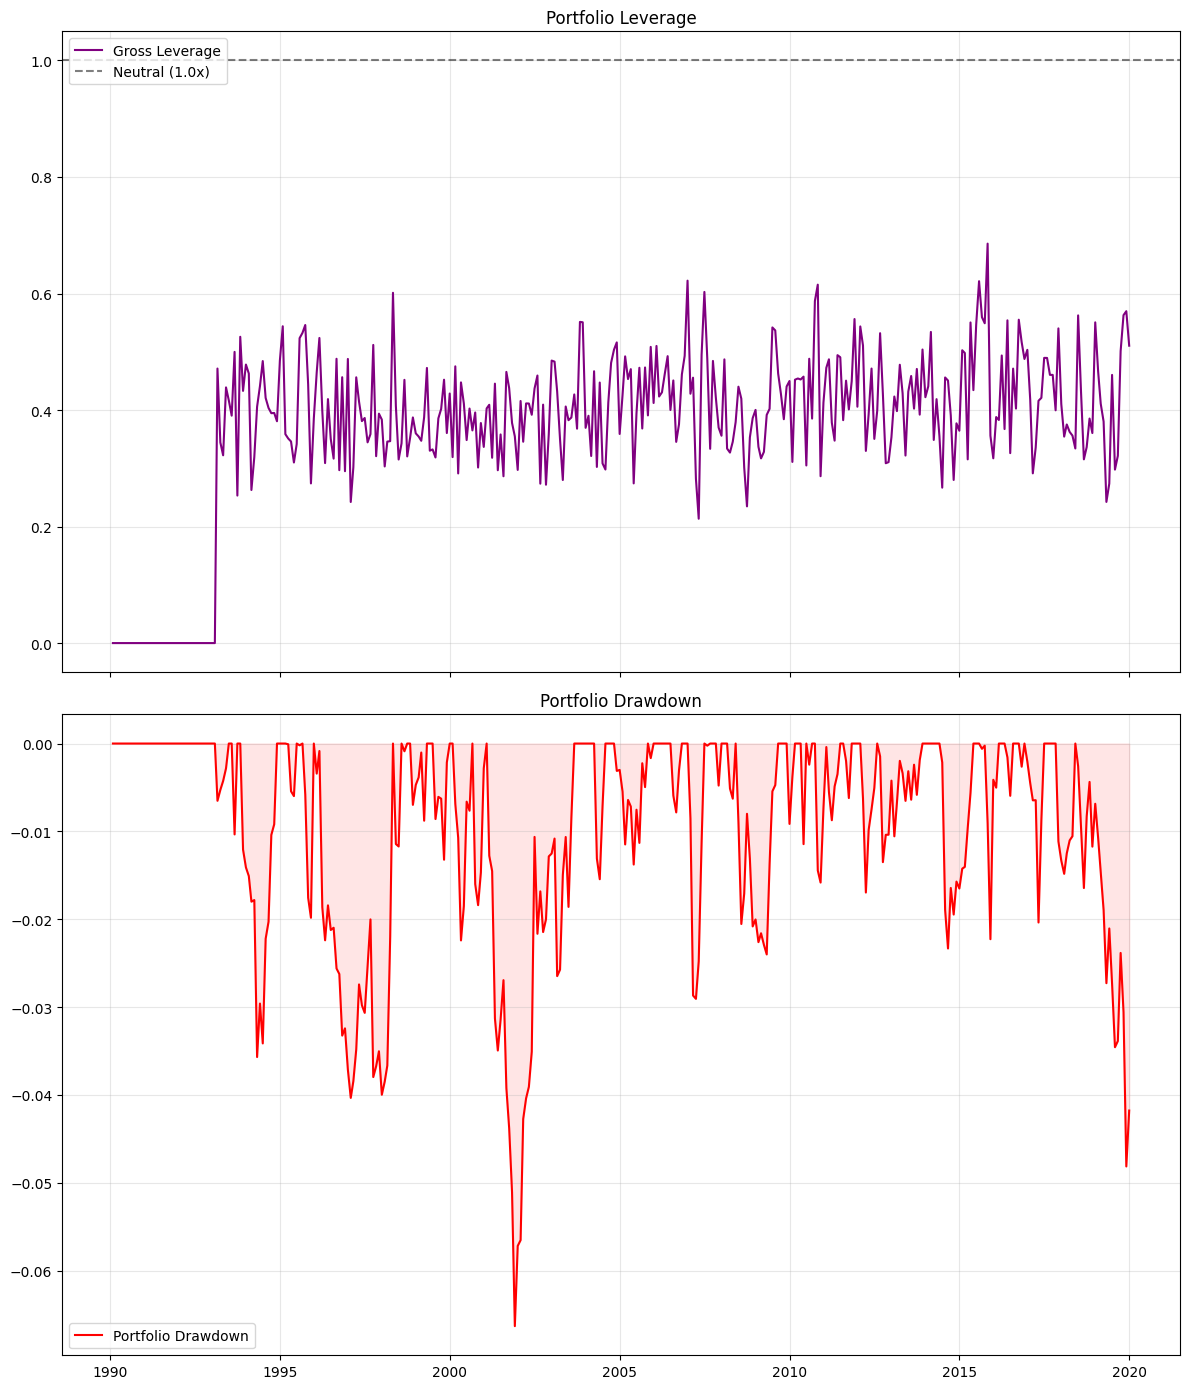

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.dates as mdates

# --- 1. SYNTHETIC DATA GENERATION ---
np.random.seed(42)
dates = pd.date_range(start="1990-01-01", periods=360, freq="M") # 30 years
assets = {}
names = ["US_SPX", "China_MXCH", "Australia_MXAU", "Japan_MXJP", 
         "Europe_MXEM", "Emerging_MXEF", "Swiss_SPI"]

# Create different trends to make them distinguishable
trends = [0.006, 0.008, 0.005, 0.002, 0.005, 0.007, 0.004]
vols = [0.04, 0.08, 0.05, 0.05, 0.04, 0.07, 0.035]

for name, mu, sigma in zip(names, trends, vols):
    returns = np.random.normal(mu, sigma, size=len(dates))
    price = 100 * (1 + returns).cumprod()
    df = pd.DataFrame({"Date": dates, "Price": price}) 
    assets[name] = df

# --- CONFIGURATION ---
LOOKBACKS = [1, 3, 12]
VOL_LOOKBACK = 36
VOL_TARGET = 0.10
TRADING_MONTHS_PER_YEAR = 12
RISK_FREE_RATE_ANNUAL = 0.02
monthly_rfr = RISK_FREE_RATE_ANNUAL / 12

def get_cost_series(dates):
    years = dates.year
    return np.where(years <= 1992, 0.0034,
           np.where(years <= 2002, 0.0011, 0.0006))

all_strategy_rets = pd.DataFrame()
all_positions = pd.DataFrame()

# --- MAIN LOOP ---
for name, df in assets.items():
    s = df.copy()
    s = s.set_index("Date")
    s["price"] = s["Price"]
    s["ret"] = s["price"].pct_change()
    
    # Signals
    signal_cols = []
    for lag in LOOKBACKS:
        col = f"sig_{lag}m"
        s[col] = np.sign(s["price"].pct_change(lag)).fillna(0)
        signal_cols.append(col)
    
    s["raw_signal"] = s[signal_cols].mean(axis=1) if signal_cols else 0
    
    # Vol Scaling
    s["hist_vol"] = s["ret"].rolling(VOL_LOOKBACK).std() * np.sqrt(12)
    s["vol_scalar"] = (VOL_TARGET / s["hist_vol"]).replace([np.inf, -np.inf], 0).fillna(0)
    s["vol_scalar"] = s["vol_scalar"].clip(upper=3.0)
    
    # Position
    s["position"] = (s["raw_signal"] * s["vol_scalar"]).shift(1).fillna(0)
    
    # Returns
    gross = s["position"] * s["ret"]
    costs = s["position"].diff().abs() * get_cost_series(s.index)
    funding = (s["position"] - 1.0) * monthly_rfr
    s["strat_ret"] = gross - costs - funding
    
    if all_strategy_rets.empty:
        all_strategy_rets = pd.DataFrame(s["strat_ret"]).rename(columns={"strat_ret": name})
        all_positions = pd.DataFrame(s["position"]).rename(columns={"position": name})
    else:
        all_strategy_rets = all_strategy_rets.join(s["strat_ret"].rename(name), how="outer")
        all_positions = all_positions.join(s["position"].rename(name), how="outer")

# Aggregation
portfolio_ret = all_strategy_rets.mean(axis=1).fillna(0)
cum_port = (1 + portfolio_ret).cumprod()

# --- PLOTTING (MODIFIED) ---
fig, axes = plt.subplots(1, 1, sharex=True)
fig2, axes2 = plt.subplots(2, 1, figsize=(12, 14), sharex=True)

# 1. Equity Curves
ax1 = axes
colors = cm.tab10(np.linspace(0, 1, len(all_strategy_rets.columns)))

for i, col in enumerate(all_strategy_rets.columns):
    cum = (1 + all_strategy_rets[col].fillna(0)).cumprod()
    ax1.plot(cum.index, cum, color=colors[i], alpha=0.7, linewidth=1.5, label=col)

ax1.plot(cum_port.index, cum_port, color="black", linewidth=3, label="Diversified Portfolio", zorder=10)
ax1.set_title("Equity Curves: Individual Strategies vs Portfolio")
ax1.set_yscale("log")
ax1.legend(loc="upper left", fontsize='small', ncol=2)
ax1.grid(True, alpha=0.3)

# 2. Leverage
gross_leverage = all_positions.abs().sum(axis=1) / len(assets)
ax2 = axes2[0]
ax2.plot(gross_leverage.index, gross_leverage, color="purple", linewidth=1.5, label="Gross Leverage")
ax2.axhline(1.0, linestyle="--", color="black", alpha=0.5, label="Neutral (1.0x)")
ax2.set_title("Portfolio Leverage")
ax2.legend(loc="upper left")
ax2.grid(True, alpha=0.3)

# 3. Drawdown
dd = cum_port / cum_port.cummax() - 1
ax3 = axes2[1]
ax3.plot(dd.index, dd, color="red", label="Portfolio Drawdown")
ax3.fill_between(dd.index, dd, 0, color="red", alpha=0.1)
ax3.set_title("Portfolio Drawdown")
ax3.legend(loc="lower left")
ax3.grid(True, alpha=0.3)

# --- ADDING YEARS (Date Formatting) ---
# Configure x-axis to show years explicitly
locator = mdates.YearLocator(5) # Tick every 5 years
formatter = mdates.DateFormatter('%Y') # Show Year (e.g., 1995)

# Apply to the bottom axis (ax3) which is shared
ax3.xaxis.set_major_locator(locator)
ax3.xaxis.set_major_formatter(formatter)

plt.tight_layout()
plt.show()